Simulation of Fire Spreading in a Forest using Von Neumann Neighbourhood and Moore Neighbourhood Algorithms
(Evaluating Sequential and Parallel Implementations)

By Oluwatosin Olubiyi

Initialization of the Forest Grids and General Properties

In [1]:
# initializie time at start of simulation

# importing all required libraries

import time
import numpy as np
import matplotlib.pyplot as plt
from random import *
from matplotlib import animation, colors
import numba

In [2]:
## assumptions and definitions

EMPTY = 0 # 0 - empty area or cell
TREE = 1 # 1 - cell or area with non burning tree
BTREE = 2 # 2 - cell or area with burning tree
BORDER = 3 # 3 - border of the forest

probTree = 0.8 # probability of a tree
probBurning = 0.01 # probability of a tree burning
probImmune = 0.3 # probability of a tree to be immune to fire
probLightning = 0.001 # probability of lightning strike

# colorList = {EMPTY: 'brown', TREE: 'green', BTREE: 'red', BORDER: 'black'}
colorList = ['brown', '#00ff00', '#ff0000', 'orange'] # color list for visualization
cmap = colors.ListedColormap(colorList)
bounds = [EMPTY, TREE, BTREE, BORDER]
norm = colors.BoundaryNorm(bounds, cmap.N)
frame_Interval = 500 # interval between frames in milliseconds

Sequential Implementation

In [3]:

# Initialize the forest with non burning trees, empty cells, burning trees and border cells
# - initializing the discrete stochastic system with probTree & probBurning.

def forest_initializer(forest_size):
    
    print("Initializing the forest...")
    
    # initialize the forest with border cells
    forest = BORDER * np.ones((forest_size + 2, forest_size + 2))
    forest[1:forest_size + 1, 1:forest_size + 1] = EMPTY
    
    for i in range(1,forest_size + 1):
        for j in range(1,forest_size + 1):
            if random() < probTree:
                if random() < probBurning:
                    forest[i][j] = BTREE # there is a burning tree in the cell
                else:
                    forest[i][j] = TREE # there is a non burning tree in the cell
            else:
                forest[i][j] = EMPTY
        
    print("Initialization completed. \n")
    
    return forest

In [4]:

# spreading the fire using the von Neumann neighborhood algorithm

def vnn_fire_spreader(forest, forest_size):   
    print("Spreading the fire...")    
    # spreading the fire using von Neumann neighborhood
    
    for i in range(1, forest_size + 1):
        for j in range(1, forest_size + 1):
            
            if forest[i][j] == TREE: # if the cell is a tree
                # if the tree is next to a burning tree
                if (forest[i - 1][j] == BTREE or forest[i + 1][j] == BTREE or 
                        forest[i][j - 1] == BTREE or forest[i][j + 1] == BTREE):
                    if random() < probImmune: # if the tree is immune to fire
                        forest[i][j] = TREE
                    else:
                        forest[i][j] = BTREE # the tree burns
                elif random() < probLightning: # if lightning strikes the site
                    if random() < probImmune: # if the tree is immune to fire, the tree does not burn
                        forest[i][j] = TREE
                    else:
                        forest[i][j] = BTREE # the tree burns
                else:
                    forest[i][j] = TREE # the tree does not burn because there are no external conditions
            elif forest[i][j] == BTREE: # if the cell is a burning tree, then it burns down
                forest[i][j] = EMPTY
            else:  # otherwise the cell is an empty cell
                forest[i][j] = EMPTY # the cell remains empty
                
    print("Spreading completed. \n")
    
    return forest

In [5]:

# spreading the fire using the Moore neighborhood algorithm

def m_fire_spreader(forest, forest_size):
    
    #print("Spreading the fire using the Moore neighborhood...")
    
    # spreading the fire using Moore neighborhood
    for i in range(1, forest_size + 1):
        for j in range(1, forest_size + 1):
            if forest[i][j] == TREE: # if the cell is a tree
                # if the tree is next to a burning tree
                if (forest[i - 1][j] == BTREE or forest[i + 1][j] == BTREE or 
                        forest[i][j - 1] == BTREE or forest[i][j + 1] == BTREE or 
                        forest[i - 1][j - 1] == BTREE or forest[i - 1][j + 1] == BTREE or 
                        forest[i + 1][j - 1] == BTREE or forest[i + 1][j + 1] == BTREE):
                    if random() < probImmune: # if the tree is immune to fire
                        forest[i][j] = TREE
                    else:
                        forest[i][j] = BTREE # the tree burns
                elif random() < probLightning: # if lightning strikes the site
                    if random() < probImmune: # if the tree is immune to fire, the tree does not burn
                        forest[i][j] = TREE
                    else:
                        forest[i][j] = BTREE # the tree burns       
                else:
                    forest[i][j] = TREE # the tree does not burn because there are no external conditions
            elif forest[i][j] == BTREE: # if the cell is a burning tree, then it burns down
                forest[i][j] = EMPTY
            else:  # otherwise the cell is an empty cell
                forest[i][j] = EMPTY # the cell remains empty
                
    #print("Spreading completed. \n")
    
    return forest

In [6]:

# extending the boundaries of the forest using periodic boundary conditions
def wrapAndExtendBoundaries(forest, forest_size):
    """_summary_

    To make this simulation more realistic, we will extend the boundaries of the forest grid
    by creating ghost cells for the moore neighbors of the boundary cells so we can spread the fire.
    
    And since there are no grid cells in forests, it makes sense to reflect the boundaries
    using the mirror image of the grid rows and columns before applying the spread at the edges of the grid cells.   
    """
    forestWithoutBorder = forest[1:forest_size + 1, 1:forest_size + 1]
    
    rowstack = np.row_stack((forestWithoutBorder[-1, :], forestWithoutBorder, forestWithoutBorder[0, :]))
    extendedForest = np.column_stack((rowstack[:, -1], rowstack, rowstack[:, 0]))    
    
    # apply spread on the extended forest grid
    extendedForestAfterSpread = m_fire_spreader(extendedForest, forest_size)
    
    # strip the extended forest grid of the ghost cells
    forestWithoutBorder = extendedForestAfterSpread[1:forest_size + 1, 1:forest_size + 1]
    
    # add our new forest without border to the original forest grid
    forest[1:forest_size + 1, 1:forest_size + 1] = forestWithoutBorder
    
    return forest

Parallel Computing Implementation

In [7]:
# Initialize the forest with non burning trees, empty cells, burning trees and border cells
# - initializing the discrete stochastic system with probTree & probBurning.

@numba.jit(nopython=True, parallel=True)
def parallel_forest_initializer(forest_size):
    
    print("Initializing the forest...")
    
    # initialize the forest with border cells
    forest = BORDER * np.ones((forest_size + 2, forest_size + 2)) 
    forest[1:forest_size + 1, 1:forest_size + 1] = EMPTY
    
    for i in numba.prange(1, forest_size + 1):
        for j in numba.prange(1, forest_size + 1):
            if random() < probTree:
                if random() < probBurning:
                    forest[i][j] = BTREE # there is a burning tree in the cell
                else:
                    forest[i][j] = TREE # there is a non burning tree in the cell
            else:
                forest[i][j] = EMPTY
    
    print("Initialization completed. \n")
    
    return forest

In [8]:
# spreading the fire using the von Neumann neighborhood algorithm

@numba.jit(nopython=True, parallel=True)
def parallel_vnn_fire_spreader(forest, forest_size):
    
    print("Spreading the fire...")
    
    # spreading the fire using von Neumann neighborhood
    for i in numba.prange(1, forest_size + 1):
        for j in numba.prange(1, forest_size + 1):
            if forest[i][j] == TREE: # if the cell is a tree
                # if the tree is next to a burning tree
                if (forest[i - 1][j] == BTREE or forest[i + 1][j] == BTREE or 
                        forest[i][j - 1] == BTREE or forest[i][j + 1] == BTREE):
                    if random() < probImmune: # if the tree is immune to fire
                        forest[i][j] = TREE
                    else:
                        forest[i][j] = BTREE # the tree burns
                elif random() < probLightning: # if lightning strikes the site
                    if random() < probImmune: # if the tree is immune to fire, the tree does not burn
                        forest[i][j] = TREE
                    else:
                        forest[i][j] = BTREE # the tree burns
                else:
                    forest[i][j] = TREE # the tree does not burn because there are no external conditions
            elif forest[i][j] == BTREE: # if the cell is a burning tree, then it burns down
                forest[i][j] = EMPTY
            else:  # otherwise the cell is an empty cell
                forest[i][j] = EMPTY # the cell remains empty
                
    print("Spreading completed. \n")
    
    return forest

In [9]:
# spreading the fire using the Moore neighborhood algorithm

@numba.jit(nopython=True, parallel=True)
def parallel_m_fire_spreader(forest, forest_size):
    
    # print("Spreading the fire using the Moore neighborhood...")
    
    # spreading the fire using Moore neighborhood
    for i in numba.prange(1, forest_size + 1):
        for j in numba.prange(1, forest_size + 1):
            if forest[i][j] == TREE: # if the cell is a tree
                # if the tree is next to a burning tree
                if (forest[i - 1][j] == BTREE or forest[i + 1][j] == BTREE or 
                        forest[i][j - 1] == BTREE or forest[i][j + 1] == BTREE or 
                        forest[i - 1][j - 1] == BTREE or forest[i - 1][j + 1] == BTREE or 
                        forest[i + 1][j - 1] == BTREE or forest[i + 1][j + 1] == BTREE):
                    if random() < probImmune: # if the tree is immune to fire
                        forest[i][j] = TREE
                    else:
                        forest[i][j] = BTREE # the tree burns
                elif random() < probLightning: # if lightning strikes the site
                    if random() < probImmune: # if the tree is immune to fire, the tree does not burn
                        forest[i][j] = TREE
                    else:
                        forest[i][j] = BTREE # the tree burns       
                else:
                    forest[i][j] = TREE # the tree does not burn because there are no external conditions
            elif forest[i][j] == BTREE: # if the cell is a burning tree, then it burns down
                forest[i][j] = EMPTY
            else:  # otherwise the cell is an empty cell
                forest[i][j] = EMPTY # the cell remains empty
                
    #print("Spreading completed. \n")
    
    return forest

In [10]:
# extending the boundaries of the forest using periodic boundary conditions

def parallel_wrapAndExtendBoundaries(forest, forest_size):
    """_summary_

    To make this simulation more realistic, we will extend the boundaries of the forest grid
    by creating ghost cells for the moore neighbors of the boundary cells so we can spread the fire.
    
    And since there are no grid cells in forests, it makes sense to reflect the boundaries
    using the mirror image of the grid rows and columns before applying the spread at the edges of the grid cells.   
    """
    forestWithoutBorder = forest[1:forest_size + 1, 1:forest_size + 1]
    
    rowstack = np.row_stack((forestWithoutBorder[-1, :], forestWithoutBorder, forestWithoutBorder[0, :]))
    extendedForest = np.column_stack((rowstack[:, -1], rowstack, rowstack[:, 0]))
    
    # apply spread on the extended forest grid
    extendedForestAfterSpread = parallel_m_fire_spreader(extendedForest, forest_size)
    
    # strip the extended forest grid of the ghost cells
    forestWithoutBorder = extendedForestAfterSpread[1:forest_size + 1, 1:forest_size + 1]
    
    # add our new forest without border to the original forest grid
    forest[1:forest_size + 1, 1:forest_size + 1] = forestWithoutBorder
    
    return forest

Visualization and Animation of the Forest Fire Spread using the Sequential and Parallel Implementations (10 iterations of spreading)

In [11]:
%matplotlib inline

Sequential Visualizations

Initializing the forest...
Initialization completed. 

Forest Initialization (Sequential) completed in 0.01232259999960661 seconds
Forest Fire Spread (Sequential) completed in 0.0669159000099171 seconds


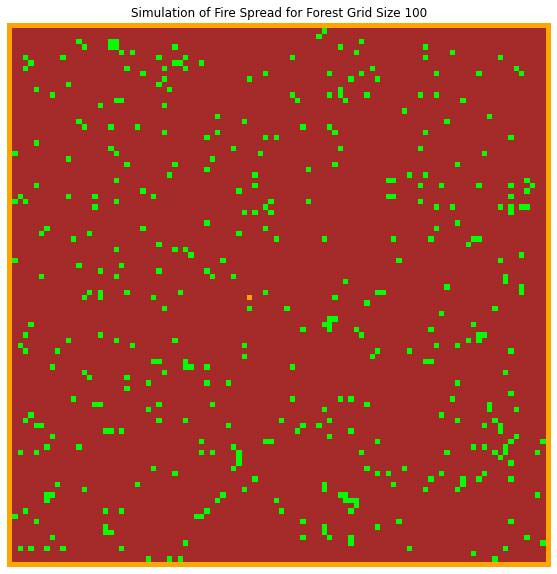

In [12]:
# time at start of visualization
initTime100 = time.perf_counter()

# generate the forest grid
forest_size100 = 100
forestGrid100 = forest_initializer(forest_size100)

print('Forest Initialization (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime100))

forestGrid100_eval = wrapAndExtendBoundaries(forestGrid100, forest_size100)

print('Forest Fire Spread (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime100))

# initialize the plot for the forest
fig100 = plt.figure(figsize=(10, 10))
ax = fig100.add_subplot(111)
ax.set_axis_off()
forestSite100 = ax.imshow(forestGrid100, cmap=cmap, norm=norm)
ax.set_title('Simulation of Fire Spread for Forest Grid Size {0}'.format(forest_size100))

# The animation function: called to produce a frame for each fire spread.
def animate100(i):
    forestSite100.set_data(animate100.Site)
    
    # we will use the moore neighborhood algorithm for spreading the fire
    animate100.Site = wrapAndExtendBoundaries(animate100.Site, forest_size100)
    
# # Bind the grid to the Site identifier in the animate function's namespace.
animate100.Site = forestGrid100

# display the forest fire images
anim100 = animation.FuncAnimation(fig100, animate100, interval=frame_Interval, frames=50)
anim100.save('forest_fire_moore_neighborhood_{0}.gif'.format(forest_size100))

plt.show()

Initializing the forest...
Initialization completed. 

Forest Initialization (Sequential) completed in 0.16854509999393485 seconds
Forest Fire Spread (Sequential) completed in 0.9428397000010591 seconds


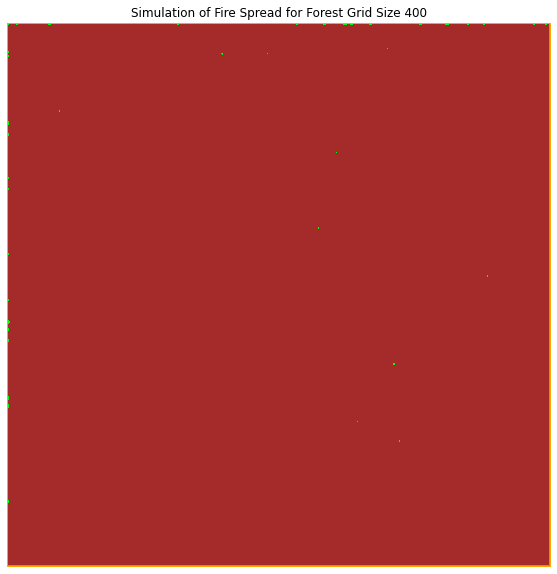

In [13]:
# time at start of visualization
initTime400 = time.perf_counter()

# generate the forest grid
forest_size400 = 400
forestGrid400 = forest_initializer(forest_size400)

print('Forest Initialization (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime400))

forestGrid400_eval = m_fire_spreader(forestGrid400, forest_size400)

print('Forest Fire Spread (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime400))

# initialize the plot for the forest
fig400 = plt.figure(figsize=(10, 10))
ax = fig400.add_subplot(111)
ax.set_axis_off()
forestSite400 = ax.imshow(forestGrid400, cmap=cmap, norm=norm)
ax.set_title('Simulation of Fire Spread for Forest Grid Size {0}'.format(forest_size400))

# The animation function: called to produce a frame for each fire spread.
def animate400(i):
    forestSite400.set_data(animate400.Site)
    
    # we will use the moore neighborhood algorithm for spreading the fire
    animate400.Site = wrapAndExtendBoundaries(animate400.Site, forest_size400)
    
# Bind the grid to the Site identifier in the animate function's namespace.
animate400.Site = forestGrid400

# display the forest fire images
anim400 = animation.FuncAnimation(fig400, animate400, interval=frame_Interval, frames=50)
anim400.save('forest_fire_moore_neighborhood_{0}.gif'.format(forest_size400))

plt.show()

Initializing the forest...
Initialization completed. 

Forest Initialization (Sequential) completed in 0.4577032000015606 seconds
Forest Fire Spread (Sequential) completed in 2.8264817999988736 seconds


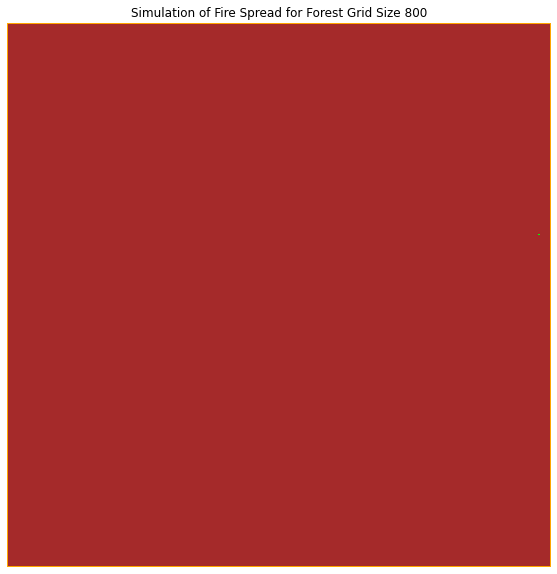

In [14]:
# time at start of visualization
initTime800 = time.perf_counter()

# generate the forest grid
forest_size800 = 800
forestGrid800 = forest_initializer(forest_size800)

print('Forest Initialization (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime800))

forestGrid800_eval = wrapAndExtendBoundaries(forestGrid800, forest_size800)

print('Forest Fire Spread (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime800))

# initialize the plot for the forest
fig800 = plt.figure(figsize=(10, 10))
ax = fig800.add_subplot(111)
ax.set_axis_off()
forestSite800 = ax.imshow(forestGrid800, cmap=cmap, norm=norm)
ax.set_title('Simulation of Fire Spread for Forest Grid Size {0}'.format(forest_size800))

# The animation function: called to produce a frame for each fire spread.
def animate800(i):
    forestSite800.set_data(animate800.Site)
    
    # we will use the moore neighborhood algorithm for spreading the fire
    animate800.Site = wrapAndExtendBoundaries(animate800.Site, forest_size800)
    
# Bind the grid to the Site identifier in the animate function's namespace.
animate800.Site = forestGrid800

# display the forest fire images
anim800 = animation.FuncAnimation(fig800, animate800, interval=frame_Interval, frames=50)
anim800.save('forest_fire_moore_neighborhood_{0}.gif'.format(forest_size800))

plt.show()

Initializing the forest...
Initialization completed. 

Forest Initialization (Sequential) completed in 0.7890270999996574 seconds
Forest Fire Spread (Sequential) completed in 5.45051699999749 seconds


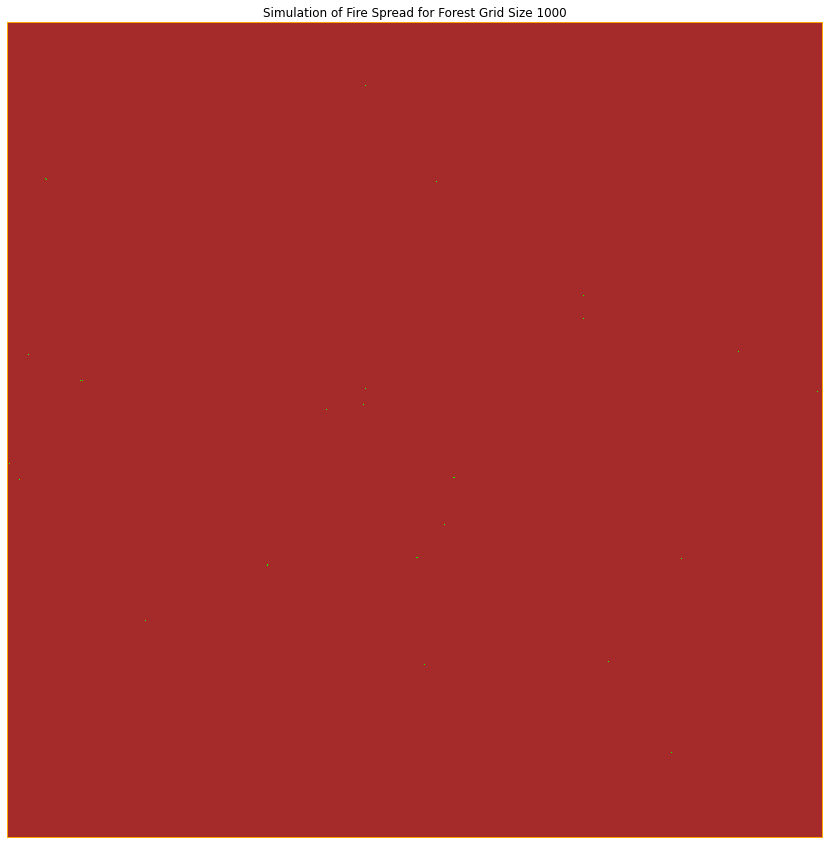

In [15]:
# time at start of visualization
initTime1000 = time.perf_counter()

# generate the forest grid
forest_size1000 = 1000
forestGrid1000 = forest_initializer(forest_size1000)

print('Forest Initialization (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime1000))

forestGrid1000_eval = wrapAndExtendBoundaries(forestGrid1000, forest_size1000)

print('Forest Fire Spread (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime1000))

# initialize the plot for the forest
fig1000 = plt.figure(figsize=(15, 15))
ax = fig1000.add_subplot(111)
ax.set_axis_off()
forestSite1000 = ax.imshow(forestGrid1000, cmap=cmap, norm=norm)
ax.set_title('Simulation of Fire Spread for Forest Grid Size {0}'.format(forest_size1000))

# The animation function: called to produce a frame for each fire spread.
def animate1000(i):
    forestSite1000.set_data(animate1000.Site)
    
    # we will use the moore neighborhood algorithm for spreading the fire
    animate1000.Site = wrapAndExtendBoundaries(animate1000.Site, forest_size1000)
    
# Bind the grid to the Site identifier in the animate function's namespace.
animate1000.Site = forestGrid1000

# display the forest fire images
anim1000 = animation.FuncAnimation(fig1000, animate1000, interval=frame_Interval, frames=50)
anim1000.save('forest_fire_moore_neighborhood_{0}.gif'.format(forest_size1000))

plt.show()

Initializing the forest...
Initialization completed. 

Forest Initialization (Sequential) completed in 1.015461899998627 seconds
Forest Fire Spread (Sequential) completed in 6.53292109999893 seconds


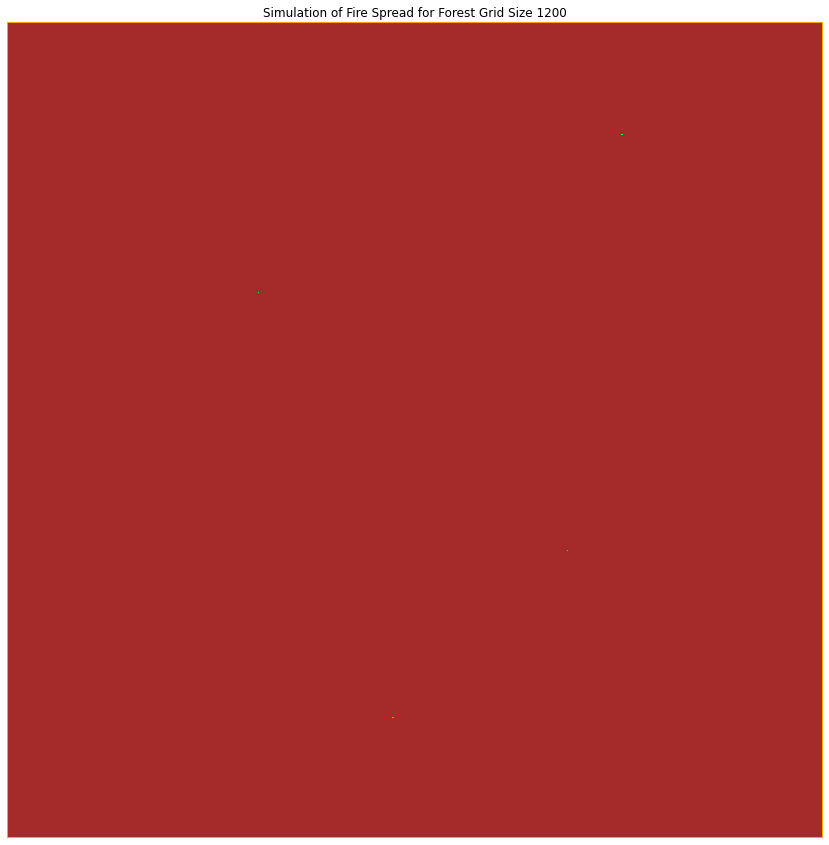

In [16]:
# time at start of visualization
initTime1200 = time.perf_counter()

# generate the forest grid
forest_size1200 = 1200
forestGrid1200 = forest_initializer(forest_size1200)

print('Forest Initialization (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime1200))

forestGrid1200_eval = wrapAndExtendBoundaries(forestGrid1200, forest_size1200)

print('Forest Fire Spread (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime1200))

# initialize the plot for the forest
fig1200 = plt.figure(figsize=(15, 15))
ax = fig1200.add_subplot(111)
ax.set_axis_off()
forestSite1200 = ax.imshow(forestGrid1200, cmap=cmap, norm=norm)
ax.set_title('Simulation of Fire Spread for Forest Grid Size {0}'.format(forest_size1200))

# The animation function: called to produce a frame for each fire spread.
def animate1200(i):
    forestSite1200.set_data(animate1200.Site)
    
    # we will use the moore neighborhood algorithm for spreading the fire
    animate1200.Site = wrapAndExtendBoundaries(animate1200.Site, forest_size1200)
    
# Bind the grid to the Site identifier in the animate function's namespace.
animate1200.Site = forestGrid1200

# display the forest fire images
anim1200 = animation.FuncAnimation(fig1200, animate1200, interval=frame_Interval, frames=50)
anim1200.save('forest_fire_moore_neighborhood_{0}.gif'.format(forest_size1200))

plt.show()

Initializing the forest...
Initialization completed. 

Forest Initialization (Sequential) completed in 3.06078129999878 seconds
Forest Fire Spread (Sequential) completed in 18.08281999999963 seconds


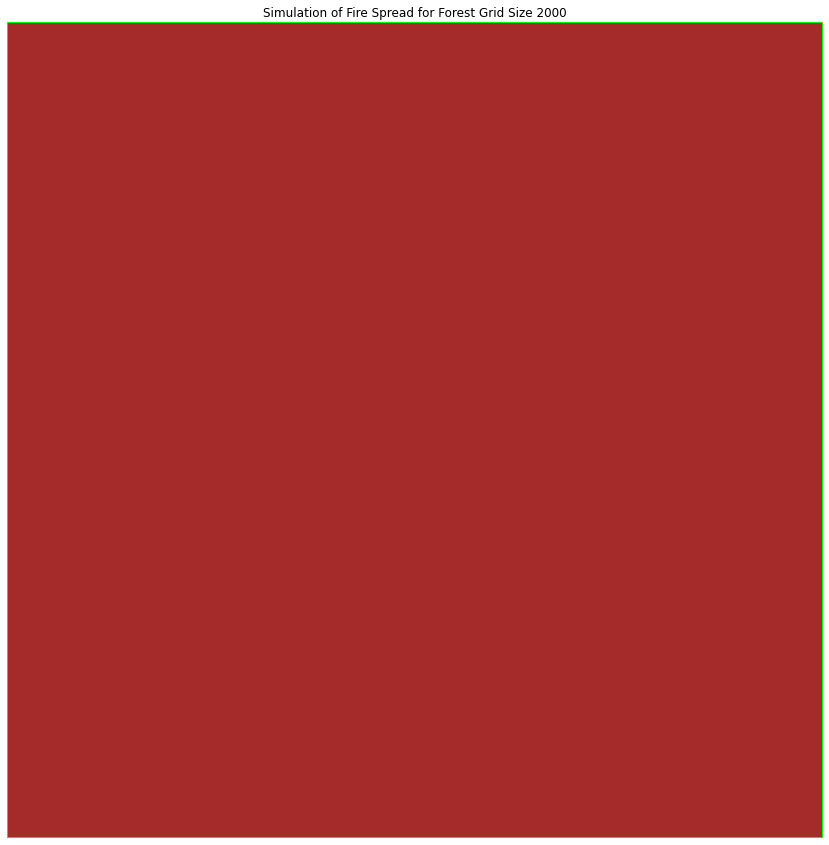

In [17]:
# time at start of visualization
initTime2000 = time.perf_counter()

# generate the forest grid
forest_size2000 = 2000
forestGrid2000 = forest_initializer(forest_size2000)

print('Forest Initialization (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime2000))

forestGrid2000_eval = wrapAndExtendBoundaries(forestGrid2000, forest_size2000)

print('Forest Fire Spread (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime2000))

# initialize the plot for the forest
fig2000 = plt.figure(figsize=(15, 15))
ax = fig2000.add_subplot(111)
ax.set_axis_off()
forestSite2000 = ax.imshow(forestGrid2000, cmap=cmap, norm=norm)
ax.set_title('Simulation of Fire Spread for Forest Grid Size {0}'.format(forest_size2000))

# The animation function: called to produce a frame for each fire spread.
def animate2000(i):
    forestSite2000.set_data(animate2000.Site)
    
    # we will use the moore neighborhood algorithm for spreading the fire
    animate2000.Site = wrapAndExtendBoundaries(animate2000.Site, forest_size2000)
    
# Bind the grid to the Site identifier in the animate function's namespace.
animate2000.Site = forestGrid2000

# display the forest fire images
anim2000 = animation.FuncAnimation(fig2000, animate2000, interval=frame_Interval, frames=50)
anim2000.save('forest_fire_moore_neighborhood_{0}.gif'.format(forest_size2000))

plt.show()

Parallel Visualizations

Initializing the forest...
Initialization completed. 

Initializing the forest...
Initialization completed. 

Forest Initialization (Parallel) completed in 0.0013030999980401248 seconds
Forest Fire Spread (Parallel) completed in 0.0019725000020116568 seconds


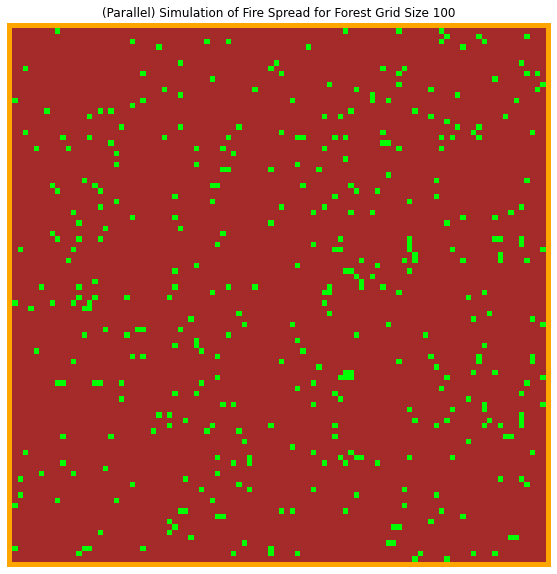

In [14]:
# useful for compiling the functions before measuring time for different forest sizes
forest_size100 = 100
forestGrid100 = parallel_forest_initializer(forest_size100)
forestGrid100 = parallel_wrapAndExtendBoundaries(forestGrid100, forest_size100)

# time at start of visualization
initTime100 = time.perf_counter()

# generate the forest grid
forestGrid100 = parallel_forest_initializer(forest_size100)

print('Forest Initialization (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime100))

forestGrid100_eval = parallel_wrapAndExtendBoundaries(forestGrid100, forest_size100)

print('Forest Fire Spread (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime100))

# initialize the plot for the forest
fig100 = plt.figure(figsize=(10, 10))
ax = fig100.add_subplot(111)
ax.set_axis_off()
forestSite100 = ax.imshow(forestGrid100, cmap=cmap, norm=norm)
ax.set_title('(Parallel) Simulation of Fire Spread for Forest Grid Size {0}'.format(forest_size100))

# The animation function: called to produce a frame for each fire spread.
def animate100(i):
    forestSite100.set_data(animate100.Site)
    
    # we will use the moore neighborhood algorithm for spreading the fire
    animate100.Site = parallel_wrapAndExtendBoundaries(animate100.Site, forest_size100)
    
# # Bind the grid to the Site identifier in the animate function's namespace.
animate100.Site = forestGrid100

# display the forest fire images
anim100 = animation.FuncAnimation(fig100, animate100, interval=frame_Interval, frames=50)
anim100.save('forest_fire_moore_neighborhood_{0}_parallel.gif'.format(forest_size100))

plt.show()

Initializing the forest...
Initialization completed. 

Forest Initialization (Parallel) completed in 0.008747899992158636 seconds
Forest Fire Spread (Parallel) completed in 0.015634199982741848 seconds


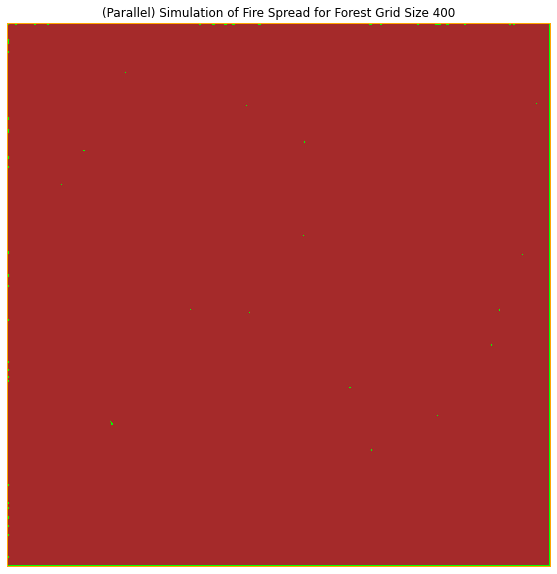

In [15]:
# time at start of visualization
initTime400 = time.perf_counter()

# generate the forest grid
forest_size400 = 400
forestGrid400 = parallel_forest_initializer(forest_size400)

print('Forest Initialization (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime400))

forestGrid400_eval = parallel_wrapAndExtendBoundaries(forestGrid400, forest_size400)

print('Forest Fire Spread (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime400))

# initialize the plot for the forest
fig400 = plt.figure(figsize=(10, 10))
ax = fig400.add_subplot(111)
ax.set_axis_off()
forestSite400 = ax.imshow(forestGrid400, cmap=cmap, norm=norm)
ax.set_title('(Parallel) Simulation of Fire Spread for Forest Grid Size {0}'.format(forest_size400))

# The animation function: called to produce a frame for each fire spread.
def animate400(i):
    forestSite400.set_data(animate400.Site)
    
    # we will use the moore neighborhood algorithm for spreading the fire
    animate400.Site = parallel_wrapAndExtendBoundaries(animate400.Site, forest_size400)
    
# Bind the grid to the Site identifier in the animate function's namespace.
animate400.Site = forestGrid400

# display the forest fire images
anim400 = animation.FuncAnimation(fig400, animate400, interval=frame_Interval, frames=50)
anim400.save('forest_fire_moore_neighborhood_{0}_parallel.gif'.format(forest_size400))

plt.show()

Initializing the forest...
Initialization completed. 

Forest Initialization (Parallel) completed in 0.02261240000007092 seconds
Forest Fire Spread (Parallel) completed in 0.04665980000208947 seconds


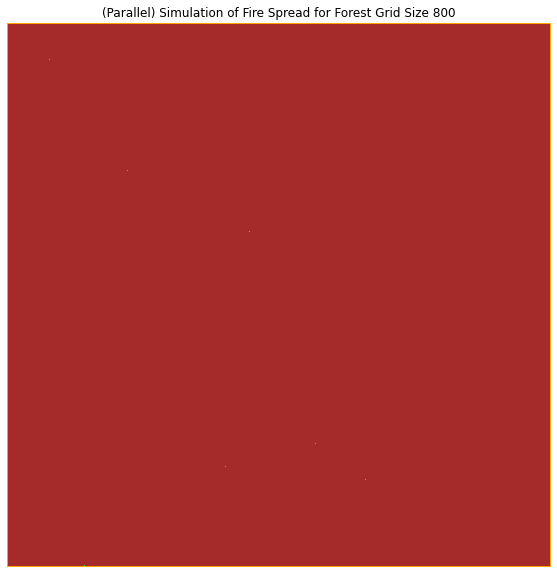

In [20]:
# time at start of visualization
initTime800 = time.perf_counter()

# generate the forest grid
forest_size800 = 800
forestGrid800 = parallel_forest_initializer(forest_size800)

print('Forest Initialization (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime800))

forestGrid800_eval = parallel_wrapAndExtendBoundaries(forestGrid800, forest_size800)

print('Forest Fire Spread (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime800))

# initialize the plot for the forest
fig800 = plt.figure(figsize=(10, 10))
ax = fig800.add_subplot(111)
ax.set_axis_off()
forestSite800 = ax.imshow(forestGrid800, cmap=cmap, norm=norm)
ax.set_title('(Parallel) Simulation of Fire Spread for Forest Grid Size {0}'.format(forest_size800))

# The animation function: called to produce a frame for each fire spread.
def animate800(i):
    forestSite800.set_data(animate800.Site)
    
    # we will use the moore neighborhood algorithm for spreading the fire
    animate800.Site = parallel_wrapAndExtendBoundaries(animate800.Site, forest_size800)
    
# Bind the grid to the Site identifier in the animate function's namespace.
animate800.Site = forestGrid800

# display the forest fire images
anim800 = animation.FuncAnimation(fig800, animate800, interval=frame_Interval, frames=50)
anim800.save('forest_fire_moore_neighborhood_{0}_parallel.gif'.format(forest_size800))

plt.show()

Initializing the forest...
Initialization completed. 

Forest Initialization (Parallel) completed in 0.02323930000056862 seconds
Forest Fire Spread (Parallel) completed in 0.052055800002563046 seconds


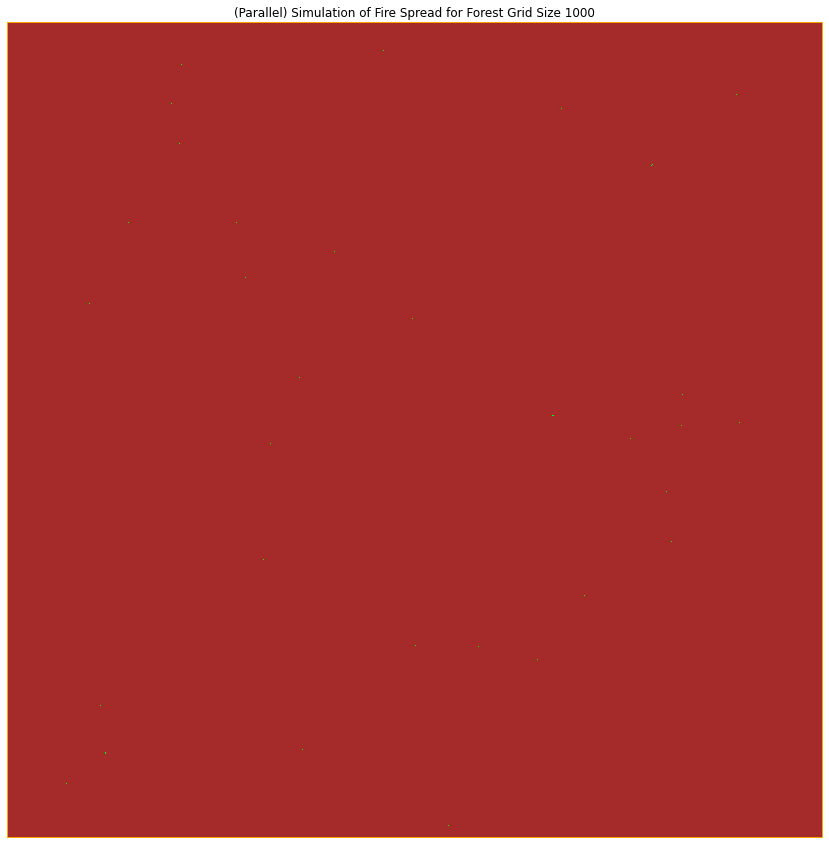

In [21]:
# time at start of visualization
initTime1000 = time.perf_counter()

# generate the forest grid
forest_size1000 = 1000
forestGrid1000 = parallel_forest_initializer(forest_size1000)

print('Forest Initialization (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime1000))

forestGrid1000_eval = parallel_wrapAndExtendBoundaries(forestGrid1000, forest_size1000)

print('Forest Fire Spread (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime1000))

# initialize the plot for the forest
fig1000 = plt.figure(figsize=(15, 15))
ax = fig1000.add_subplot(111)
ax.set_axis_off()
forestSite1000 = ax.imshow(forestGrid1000, cmap=cmap, norm=norm)
ax.set_title('(Parallel) Simulation of Fire Spread for Forest Grid Size {0}'.format(forest_size1000))

# The animation function: called to produce a frame for each fire spread.
def animate1000(i):
    forestSite1000.set_data(animate1000.Site)
    
    # we will use the moore neighborhood algorithm for spreading the fire
    animate1000.Site = parallel_wrapAndExtendBoundaries(animate1000.Site, forest_size1000)
    
# Bind the grid to the Site identifier in the animate function's namespace.
animate1000.Site = forestGrid1000

# display the forest fire images
anim1000 = animation.FuncAnimation(fig1000, animate1000, interval=frame_Interval, frames=50)
anim1000.save('forest_fire_moore_neighborhood_{0}_parallel.gif'.format(forest_size1000))

plt.show()

Initializing the forest...
Initialization completed. 

Forest Initialization (Parallel) completed in 0.03126770000017132 seconds
Forest Fire Spread (Parallel) completed in 0.07287020000148914 seconds


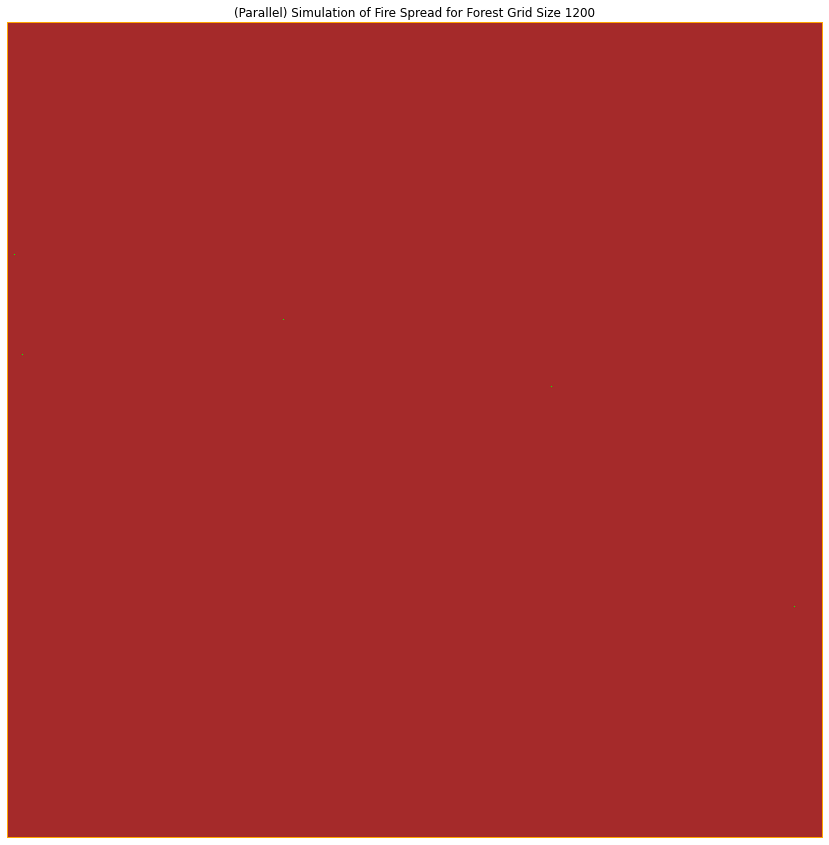

In [22]:
# time at start of visualization
initTime1200 = time.perf_counter()

# generate the forest grid
forest_size1200 = 1200
forestGrid1200 = parallel_forest_initializer(forest_size1200)

print('Forest Initialization (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime1200))

forestGrid1200_eval = parallel_wrapAndExtendBoundaries(forestGrid1200, forest_size1200)

print('Forest Fire Spread (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime1200))

# initialize the plot for the forest
fig1200 = plt.figure(figsize=(15, 15))
ax = fig1200.add_subplot(111)
ax.set_axis_off()
forestSite1200 = ax.imshow(forestGrid1200, cmap=cmap, norm=norm)
ax.set_title('(Parallel) Simulation of Fire Spread for Forest Grid Size {0}'.format(forest_size1200))

# The animation function: called to produce a frame for each fire spread.
def animate1200(i):
    forestSite1200.set_data(animate1200.Site)
    
    # we will use the moore neighborhood algorithm for spreading the fire
    animate1200.Site = parallel_wrapAndExtendBoundaries(animate1200.Site, forest_size1200)
    
# Bind the grid to the Site identifier in the animate function's namespace.
animate1200.Site = forestGrid1200

# display the forest fire images
anim1200 = animation.FuncAnimation(fig1200, animate1200, interval=frame_Interval, frames=50)
anim1200.save('forest_fire_moore_neighborhood_{0}_parallel.gif'.format(forest_size1200))

plt.show()

Initializing the forest...
Initialization completed. 

Forest Initialization (Parallel) completed in 0.09323550000044634 seconds
Forest Fire Spread (Parallel) completed in 0.2172342000012577 seconds


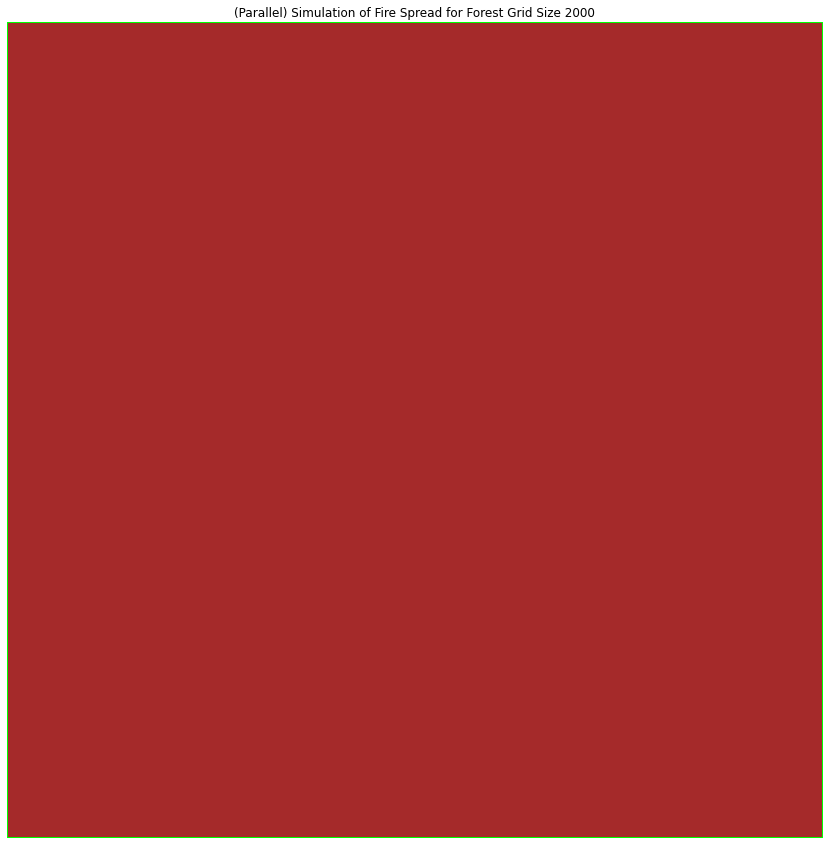

In [23]:
# time at start of visualization
initTime2000 = time.perf_counter()

# generate the forest grid
forest_size2000 = 2000
forestGrid2000 = parallel_forest_initializer(forest_size2000)

print('Forest Initialization (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime2000))

forestGrid2000_eval = parallel_wrapAndExtendBoundaries(forestGrid2000, forest_size2000)

print('Forest Fire Spread (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime2000))

# initialize the plot for the forest
fig2000 = plt.figure(figsize=(15, 15))
ax = fig2000.add_subplot(111)
ax.set_axis_off()
forestSite2000 = ax.imshow(forestGrid2000, cmap=cmap, norm=norm)
ax.set_title('(Parallel) Simulation of Fire Spread for Forest Grid Size {0}'.format(forest_size2000))

# The animation function: called to produce a frame for each fire spread.
def animate2000(i):
    forestSite2000.set_data(animate2000.Site)
    
    # we will use the moore neighborhood algorithm for spreading the fire
    animate2000.Site = parallel_wrapAndExtendBoundaries(animate2000.Site, forest_size2000)
    
# Bind the grid to the Site identifier in the animate function's namespace.
animate2000.Site = forestGrid2000

# display the forest fire images
anim2000 = animation.FuncAnimation(fig2000, animate2000, interval=frame_Interval, frames=50)
anim2000.save('forest_fire_moore_neighborhood_{0}_parallel.gif'.format(forest_size2000))

plt.show()